## Импорт необходимых библиотек

In [1]:
from numpy.random import normal
from mathtoolbox import *
from viewtoolbox import *

%matplotlib widget 

## Моделирование случайной величины с заданной корреляционной функцией

### Исходные параметры (константы)

$\bullet$ Интервал времени, на котором рассматтривается корреляция (мкс) - TIME_WINDOW_US};

$\bullet$ Частота дискретизации (МГц), ${f_d}$ - F_SAMPLING_MHZ;

$\bullet$ Среднеквадратичное отклонение (СКО), $\sigma$ - SIGMA_NORMAL;

$\bullet$ Математическое ожидаение, $m$ - MU_PARAM;

$\bullet$ Число усредняемых реализаций - N_SAMPLES.

In [2]:
# Параметры моделирования и распределения
TIME_WINDOW_US = 300    # временной интервал, на котором рассматривается корреляция, мкс
F_SAMPLING_MHZ = 20     # частота дискретизации, МГц
SIGMA_NORMAL = 11       # СКО гауссовского случайного процесса
MU_PARAM = 0            # мат. ожидание исходного процесса
N_SAMPLES = 20          # число усредняемых реализаций

### Формирование некоррелированного случайного процесса

*Исходный некоррелированный (белый) гауссовский шум:*

In [3]:
N_COUNTS = int(TIME_WINDOW_US*F_SAMPLING_MHZ)   # число отсчетов
X = normal(MU_PARAM, SIGMA_NORMAL, (N_SAMPLES, N_COUNTS))   # исходный СП (гауссовский СП)

*Отображение плотности вероятности исходного процесса:*

Функция идеальной гауссовой плотности вероятности имеет следующий вид:
$$w(x) = \frac{1}{\sqrt{2\pi}\sigma} \cdot e^{-\frac{(x - m)^2}{2\sigma^2}}.$$
При этом, огибающая гистограммы полученных отсчётов исходной реализации должна сходиться к идеальному случаю.

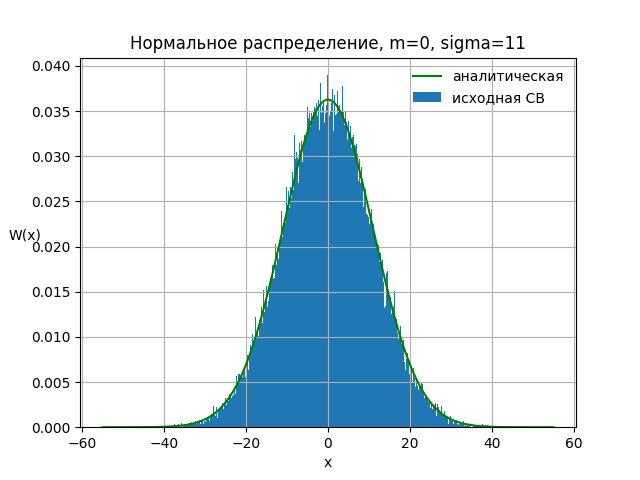

In [4]:
x_axis = np.linspace(-5*SIGMA_NORMAL, 5*SIGMA_NORMAL, 1000) # интервал значений, на котором задана плотность вероятноси
# Идеальная плотность вероятности исходного закона распределения
w_x = 1/(np.sqrt(2*np.pi)*SIGMA_NORMAL) * np.exp(-(x_axis-MU_PARAM)**2 / (2*SIGMA_NORMAL**2))

plot_distrib_with_analyt(X, x_axis, w_x, 'Нормальное распределение, m=' + str(MU_PARAM) + ', sigma=' + str(SIGMA_NORMAL))

*Корреляционная функция исходного СП:*

Для дискретного нормированного белого гауссовского шума корреляционная функция имеет вид:
$$
R[k] = 
\begin{cases}
1, k = 0 \\
0, k \neq 0 
\end{cases}
$$

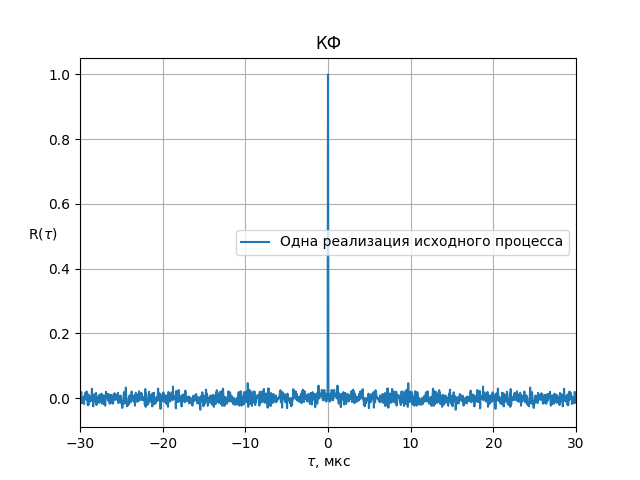

In [5]:
rx_sample, rx_est = calculate_correlate(X, N_COUNTS, N_SAMPLES)

plot_corr_func([[rx_sample, 'Одна реализация исходного процесса']], TIME_WINDOW_US, N_COUNTS, TIME_WINDOW_US/10)

*Спектральная плотность мощности (СПМ) исходного процесса:*

СПМ дискретного белого гауссовского шума имеет постоянное значение:
$$S(\omega) = S_0.$$

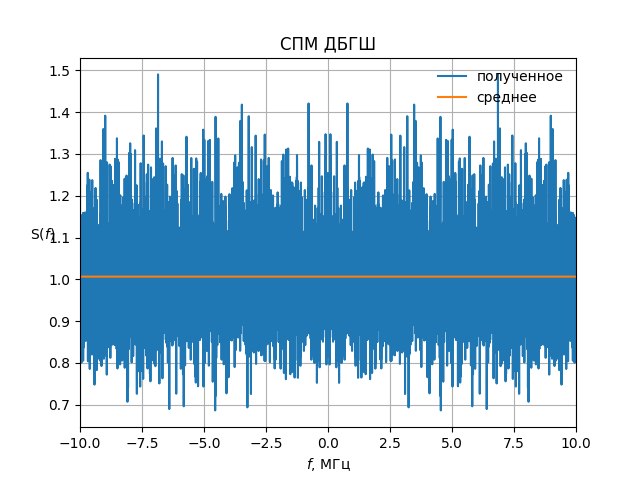

In [6]:
plot_SPD_DNWGN(rx_est, F_SAMPLING_MHZ, N_COUNTS)

### Формирование коррелированного случайного процесса

**Моделирование СП с экспоненциальной функцией корреляции**

*Корреляционная функция процесса:*

Целевая корреляционная функция имеет вид:
$$R(\tau) = e^{-\frac{|\tau|}{l}},$$
где $l$ - интервал корреляции, оцениваемый следующим образом:
$$R(\tau = l) ≈ 0,14.$$

In [7]:
ex_corr_int = 10    # интеравал корреляции, мкс
r_fun_ex : Callable[[np.ndarray, int | float], np.ndarray] = lambda x, corr: np.exp(-abs(x) / corr)  # КФ

*Получение отсчетов теоретической КФ для двух различных интервалов корреляции:*

In [8]:
# Теоретическая КФ
r_fun_l1_ex = get_corr_func(r_fun_ex, ex_corr_int, TIME_WINDOW_US, N_COUNTS)  # на заданном по варианту интервале корреляции
r_fun_l2_ex = get_corr_func(r_fun_ex, 2*ex_corr_int, TIME_WINDOW_US, N_COUNTS)    # на удвоенном интервале корреляции

*Реализации коррелированного шума на двух различных интервалах корреляции:*

In [9]:
y_l1_ex = apply_corr_filter(X, TIME_WINDOW_US, r_fun_ex, ex_corr_int)    # коррелированный СП на заданном по варианту интервале корреляции
y_l2_ex = apply_corr_filter(X, TIME_WINDOW_US, r_fun_ex, 2*ex_corr_int)    # коррелированный СП на удвоенном интервале корреляции

*Отображение плотности вероятности полученного коррелированного процесса:*

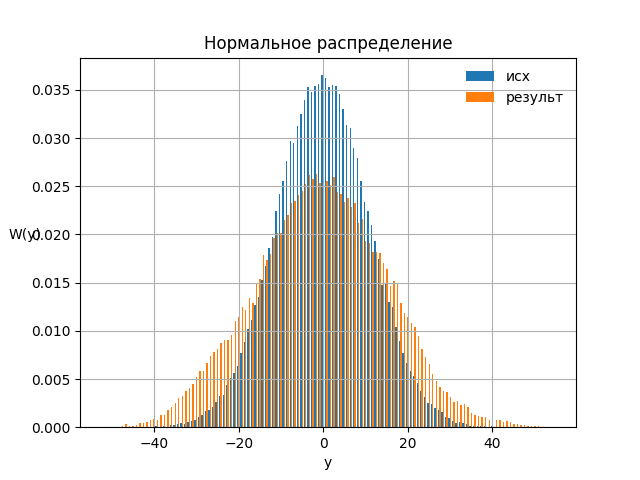

In [10]:
# Плотность распределения коррелированного процесса
plot_distrib([[X, 'исх'], [y_l1_ex, 'результ']], title='Нормальное распределение')

*Получение экспериментальной КФ:*

In [11]:
ry_sample_l1_ex, ry_est_l1_ex = calculate_correlate(y_l1_ex, N_COUNTS, N_SAMPLES) # КФ для заданного по варианту интервалу корреляции
ry_sample_l2_ex, ry_est_l2_ex = calculate_correlate(y_l2_ex, N_COUNTS, N_SAMPLES) # КФ для удвоенного интервала корреляции

*Отображение полученных КФ:*

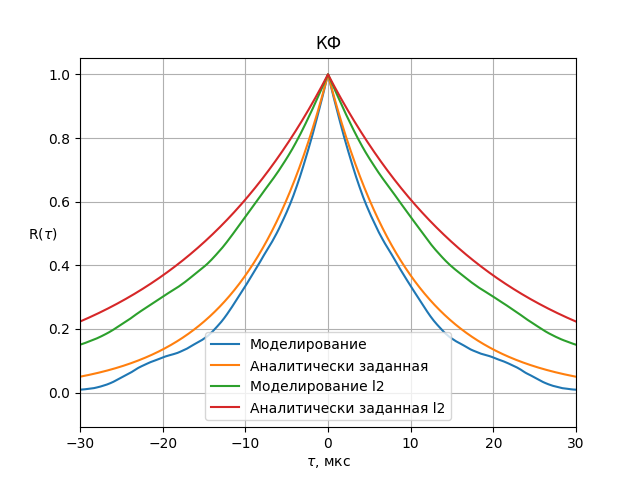

In [12]:
plot_corr_func([[ry_est_l1_ex, 'Моделирование'],
                [r_fun_l1_ex, 'Аналитически заданная'],
                [ry_est_l2_ex, 'Моделирование l2'],
                [r_fun_l2_ex, 'Аналитически заданная l2']],
                TIME_WINDOW_US,
                N_COUNTS,
                3*ex_corr_int)

*СПМ полученного процесса:*

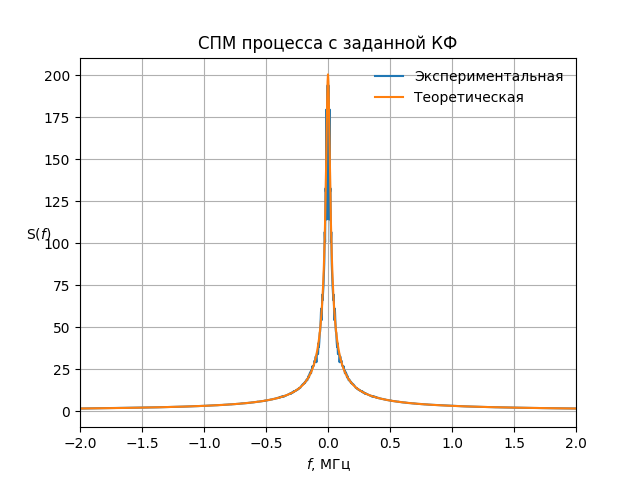

In [13]:
# СПМ процесса с заданной КФ
plot_SPD([[ry_est_l1_ex, 'Экспериментальная'], 
          [r_fun_l1_ex, 'Теоретическая']], 
          F_SAMPLING_MHZ,
          N_COUNTS, 
          0.1*F_SAMPLING_MHZ)

**Моделирование СП с корреляционной функцией, заданной по варианту**

*Корреляционная функция полученного процесса:*

Целевая корреляционная функция имеет вид:
$$R(\tau) = e^{-(\frac{\tau}{l})^2},$$
где $l$ - интервал корреляции, оцениваемый следующим образом:
$$R(\tau = l) ≈ 0,35.$$

In [14]:
corr_int_us = 10    # интеравал корреляции, мкс
r_fun : Callable[[np.ndarray, int | float], np.ndarray] = lambda x, corr: np.exp(-(x / corr)**2)  # КФ

*Получение отсчетов теоретической КФ для двух различных интервалов корреляции:*

In [15]:
# Теоретическая КФ
r_fun_l1 = get_corr_func(r_fun, corr_int_us, TIME_WINDOW_US, N_COUNTS)  # на заданном по варианту интервале корреляции
r_fun_l2 = get_corr_func(r_fun, 2*corr_int_us, TIME_WINDOW_US, N_COUNTS)    # на удвоенном интервале корреляции

*Реализации коррелированного шума на двух различных интервалах корреляции:*

In [16]:
y_l1 = apply_corr_filter(X, TIME_WINDOW_US, r_fun, corr_int_us)    # коррелированный СП на заданном по варианту интервале корреляции
y_l2 = apply_corr_filter(X, TIME_WINDOW_US, r_fun, 2*corr_int_us)    # коррелированный СП на удвоенном интервале корреляции

*Отображение плотности вероятности полученного коррелированного процесса:*

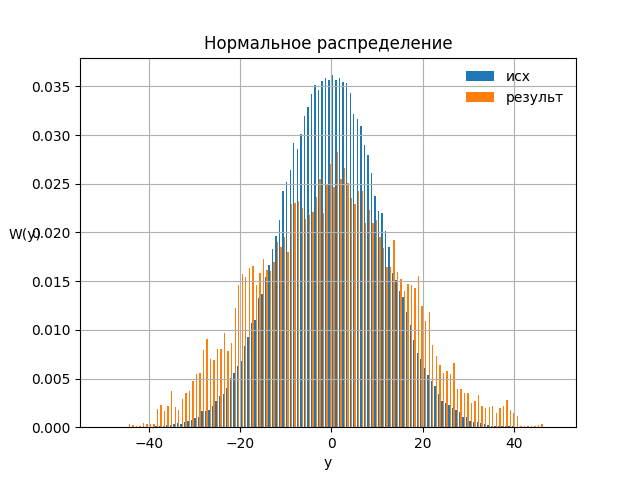

In [17]:
# Плотность распределения коррелированного процесса
plot_distrib([[X, 'исх'], [y_l1, 'результ']], title='Нормальное распределение')

*Получение экспериментальной КФ:*

In [18]:
ry_sample_l1, ry_est_l1 = calculate_correlate(y_l1, N_COUNTS, N_SAMPLES) # КФ для заданного по варианту интервалу корреляции
ry_sample_l2, ry_est_l2 = calculate_correlate(y_l2, N_COUNTS, N_SAMPLES) # КФ для удвоенного интервала корреляции

*Отображение полученных КФ:*

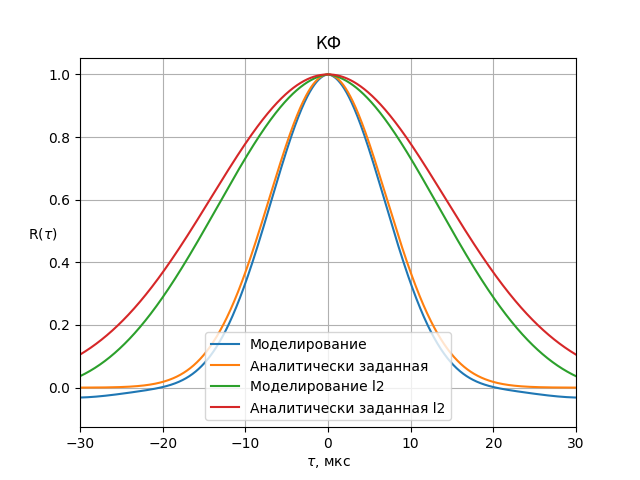

In [19]:
plot_corr_func([[ry_est_l1, 'Моделирование'],
                [r_fun_l1, 'Аналитически заданная'],
                [ry_est_l2, 'Моделирование l2'],
                [r_fun_l2, 'Аналитически заданная l2']],
                TIME_WINDOW_US,
                N_COUNTS,
                3*corr_int_us)

*СПМ полученного процесса:*

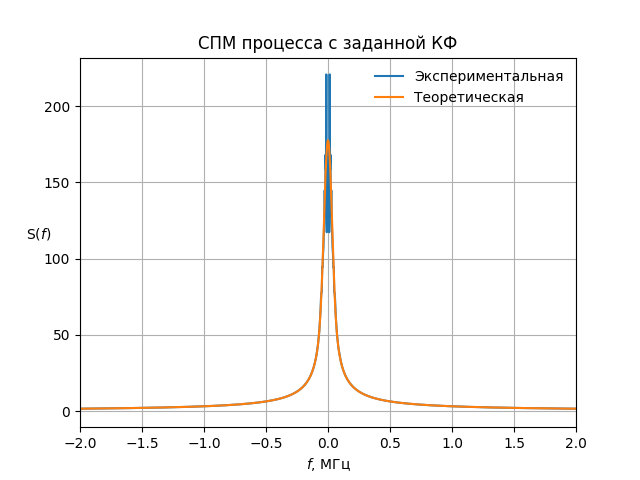

In [20]:
# СПМ процесса с заданной КФ
plot_SPD([[ry_est_l1, 'Экспериментальная'], 
          [r_fun_l1, 'Теоретическая']], 
          F_SAMPLING_MHZ,
          N_COUNTS, 
          0.1*F_SAMPLING_MHZ)